In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/deependran7/Datasets/master/hourly_data.csv')
I_r = data.ghi.to_list()
Q = data.discharge.to_list()
P_load = data.p.to_list()
Q_load = data.q.to_list()
K_load = data.kva.to_list()
w_speed = data.wind_speed.to_list()
data = data.set_index('date')

In [ ]:
class Load_model:
    def __init__(self, load_profile,factor):
        self.loading = np.array(load_profile)*factor
    def Power(self):
        return self.loading

In [ ]:
class PV_model:
    pv_cc = 618;
    pv_om = 10;
    dr = 0.1;
    n = 25;
    crf = (dr*(1+dr)**n)/(((1+dr)**n)-1); 
    
    def __init__(self, N_pv,I_r):
        self.N_pv = N_pv
        self.I_r = I_r
    def Power(self):
        power = [0]*len(self.I_r)
        for k in range(len(self.I_r)):
            power[k] = self.N_pv*(self.I_r[k]/1000)
        return np.array(power)
    def Cost(self):
        return self.N_pv * (self.pv_cc +self.pv_om/self.crf);

    def set_Npv(self, npv):
      self.N_pv = npv

In [ ]:
class Wind_model:
    wind_cc = 618;
    wind_om = 10;
    dr = 0.1;
    n = 25;
    crf = (dr*(1+dr)**n)/(((1+dr)**n)-1); 
    A = (np.pi*4**2)/4
    rho = 1.225
    P_base = 0.4*A* rho 
    
    def __init__(self, N_wt,ws,ws_cutin, ws_cutout):
        self.N_wt = N_wt
        self.ws = ws
        self.ws_cutin = ws_cutin
        self.ws_cutout = ws_cutout
    def Power(self):
        power = [0]*len(self.ws)
        for k in range(len(self.ws)):
          if self.ws_cutout <= self.ws[k]:
            power[k] = self.N_wt*self.P_base*(self.ws_cutout)**3
          if self.ws_cutin < self.ws[k] and self.ws_cutout > self.ws[k]:
            power[k] = self.N_wt*self.P_base*(self.ws[k])**3
          if self.ws_cutin > self.ws[k]:
            power[k] = 0
        return np.array(power)/1000
    def Cost(self):
        return self.N_wt * (self.wind_cc + self.wind_om/self.crf);
    
    def set_N_t(self,N_wt):
      self.N_wt = N_wt

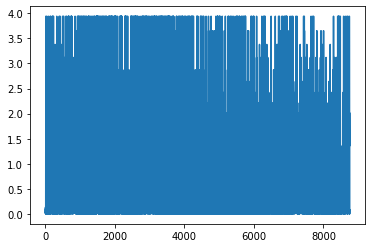

In [ ]:
wind = Wind_model(10,w_speed,0.3,4)
out = wind.Power()
plt.plot(out)

In [ ]:
class Battery_model:
    sigma = 0.0001
    eta_inv = 0.9
    eta_bd = 0.9
    eta_bc = 0.9
    C_b = 2.42
    DOD = 0.8
    Soc = [0.5]*8761
    P_bat = [0]*8761
    nb_cc = 200
    nb_om = 0
    nb_rep = 200
    dr = 0.1;
    n = 25;
    crf = (dr*(1+dr)**n)/(((1+dr)**n)-1); 
    
    def __init__(self, N_b,Delta_P):
        self.N_b  = N_b
        self.Delta_P = Delta_P
    
    def SOC(self):
        for k in range(1,len(self.Delta_P)):
            if self.Delta_P[k-1] > 0:
                if self.Soc[k-1] >=1:
                    self.Soc[k] = 1
                    
                else:
                    if self.Delta_P[k-1] >=self.N_b*self.C_b:
                        power = self.N_b*self.C_b
                        self.Soc[k] = self.Soc[k-1]*(1-self.sigma) + (power)*self.eta_bc/(self.N_b*self.C_b)
                        
                    else:
                        power = self.Delta_P[k-1]
                        self.Soc[k] = self.Soc[k-1]*(1-self.sigma) + (power)*self.eta_bc/(self.N_b*self.C_b)
                        
                if self.Soc[k]>=1:
                    self.Soc[k] = 1
                   
            if self.Delta_P[k-1] < 0:
                if (self.Soc[k-1])<= (1-self.DOD):
                    self.Soc[k] = 1-self.DOD
                    
                else:
                    self.Soc[k] = self.Soc[k-1]*(1-self.sigma)+ self.Delta_P[k-1]/(self.eta_bd*self.N_b*self.C_b)
                    self.P_bat[k]=-self.Delta_P[k]
                if (self.Soc[k] <=(1-self.DOD)):
                    self.Soc[k] = 1-self.DOD
        return np.array(self.Soc)
      

    def Power(self):
      self.SOC()
      for k in range(1,len(self.Delta_P)):
        if self.Soc[k-1] >= self.Soc[k]:
          #battery discharges
          self.P_bat[k-1] = (self.Soc[k-1]-self.Soc[k]*(1-self.sigma))*self.eta_bd*self.N_b*self.C_b 
        else:
          #battery charges
          self.P_bat[k-1] = (self.Soc[k-1]-self.Soc[k]*(1-self.sigma))*self.eta_bc*self.N_b*self.C_b 
      return np.array(self.P_bat)
    
    def calc_rep(self):
      return (1/(1+self.dr)**5 + 1/(1+self.dr)**10 + 1/(1+self.dr)**15 + 1/(1+self.dr)**20)
    
    def Cost(self):
        return self.N_b * (self.nb_cc +self.nb_om/self.crf) + self.N_b * self.nb_rep * self.calc_rep() ;

    def set_Nb(self, nb):
      self.N_b = nb
    
    def set_deltaP(self, dP):
      self.Delta_P = dP
    

In [ ]:
class ELC:
    elc_r = 0
    cc_elc= 150
    om_elc=150*5/100
    dr = 0.1;
    n = 25;
    crf = (dr*(1+dr)**n)/(((1+dr)**n)-1); 
    def __init__(self,load,battery,*Power_sources):
        self.Power_sources = Power_sources
        self.load = load
        self.battery = battery
        
    def Power(self):
        residual_power = 0
        for power_source in self.Power_sources:
            residual_power = residual_power + power_source.Power()
        return residual_power-self.load.Power()+self.battery.Power()
    def Cost(self):
        self.elc_r = max(self.Power())
        return (self.elc_r*self.cc_elc + self.om_elc * self.elc_r/self.crf )  

    def set_power_sources(self,*Power_sources):
      self.Power_sources = Power_sources

In [ ]:
class Inverter_model:
  eta_inv = 0.98
  inv_cc = 200
  inv_om = 0
  inv_rep = 200
  dr = 0.1;
  def __init__(self, Battery_model, pf):
    self.Battery_model = Battery_model
    self.pf  = pf

  def Power(self):
    return self.Battery_model.Power()*self.eta_inv
  
  def calc_rep(self):
      return (1/(1+self.dr)**10 + 1/(1+self.dr)**20)

  def calc_kva(self):
    return self.Battery_model.N_b * self.Battery_model.C_b/self.pf
  def Cost(self):
    return (self.inv_cc * self.calc_kva() +self.inv_rep*self.calc_kva()*self.calc_rep()) 

In [ ]:
delta_P = [0]*len(data)
wind = Wind_model(2,w_speed,0.3,4)
solar = PV_model(1, I_r)
load = Load_model(P_load,0.4)
battery = Battery_model(1,delta_P)
elc = ELC(load,battery)
inv = Inverter_model(battery, 0.85)

In [ ]:
def Loss_function(x=None):
    wind.set_N_t(x[1])
    solar.set_Npv(x[0])
    delta_P = wind.Power() + solar.Power() - load.Power()
    battery.set_Nb(x[2])
    battery.set_deltaP(delta_P)
    elc.set_power_sources(wind,solar)
    outage = 0
    el = elc.Power()
    for k in range(len(I_r)):
        out = el[k]
        if out < 0:
            outage = outage + 1
    #print(outage) 
    if (outage) < 200:
        z = wind.Cost() + solar.Cost() + battery.Cost() + inv.Cost()
        return z
    else:
        return 100000000

In [ ]:
pip install geneticalgorithm

     |████████████████████████████████| 44 kB 1.2 MB/s 
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15098 sha256=eeeb058a2484cc2889e56b515e52610e9cc7a744b132d041de0df2f4040a2bb4
  Stored in directory: /root/.cache/pip/wheels/68/b5/a5/67c4364c354e141f5a1bd3ec568126f77877ab7554cf5af8cb
Successfully built func-timeout


In [ ]:
from geneticalgorithm import geneticalgorithm as ga

In [ ]:
algorithm_param = {'max_num_iteration': 50,\
                   'population_size':50,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

varbound=np.array([[1,100],[1,100],[1,100]])

model=ga(function=Loss_function,dimension=3,variable_type='real',variable_boundaries=varbound,algorithm_parameters=algorithm_param)

#model.run()

In [ ]:
#a = model.best_variable
#a

In [ ]:
a = np.array([ 9.90217401, 100.43642465, 77.76057635])

In [ ]:
PV_size = a[0];
Win_size= a[1];
wind = Wind_model(Win_size,w_speed,0.3,4)
solar = PV_model(a[0], I_r)
load = Load_model(P_load,0.4)
delta_P = wind.Power() + solar.Power() - load.Power()
battery = Battery_model(a[2],delta_P)
elc = ELC(load,battery,solar,wind)

In [ ]:
plot_data = pd.DataFrame()
plot_data['P_solar'] = solar.Power()
plot_data['P_wind']=wind.Power()
plot_data['P_load']= load.Power()
plot_data['SOC'] = battery.SOC()
plot_data['P_bat']=battery.Power()
plot_data['P_elc']=elc.Power()

In [ ]:
columns = ['P_wind', 'P_solar', 'P_load','P_elc']
power_data = pd.DataFrame(plot_data, columns=columns)

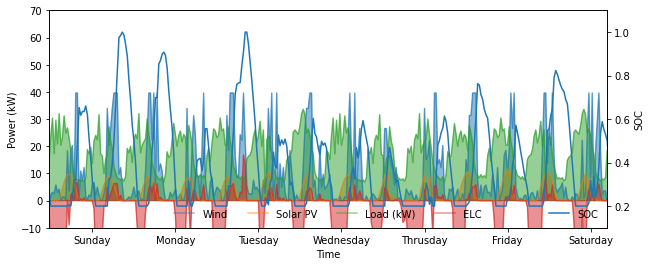

In [ ]:
labels = ['Sunday','Monday','Tuesday','Wednesday','Thrusday','Friday','Saturday']
x = np.arange(3050,3351, 50)
fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(10,4)
power_data.plot.area(xlim =[9*14*24, 10*14*24], ylim =[-10, 70], ax = ax1, stacked = False)


ax1.set_xlabel('Time')
ax1.set_ylabel('Power (kW)')
ax1.legend(['Wind','Solar PV', 'Load (kW)', 'ELC'],loc='lower center',frameon=False, ncol=5)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
plot_data.SOC.plot(xlim =[9*14*24, 10*14*24], ylim =[0.1, 1.1], ax = ax2)
ax2.set_ylabel('SOC')
ax2.legend(['SOC'],loc ='lower right',frameon = False)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)

plt.savefig('sharing.jpeg',bbox_inches = 'tight',dpi=300)
plt.show()
#files.download('sharing.png')

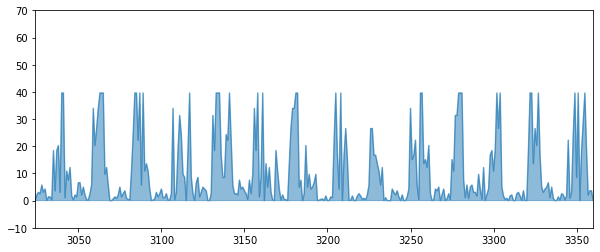

In [ ]:
fig,ax1 = plt.subplots(1,1)
fig.set_size_inches(10,4)
power_data.P_wind.plot.area(xlim =[9*14*24, 10*14*24], ylim =[-10, 70], ax = ax1, stacked = False)

In [ ]:
pip install fitter

     |████████████████████████████████| 47 kB 3.6 MB/s 
  Created wheel for fitter: filename=fitter-1.4.0-py3-none-any.whl size=25026 sha256=064f0b527681afe0b679c6bdd434e646d9139fb09919c9d2e420fe45f2cbb266
  Stored in directory: /root/.cache/pip/wheels/e1/98/16/e5263962f94fbfaad79902aa94652516caccc1f1d51509e853
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=425813bb3eccd4bac2335b6df1a3ee36fb1074f2f454ad5e53b7ffc7264c3f2a
  Stored in directory: /root/.cache/pip/wheels/82/ab/83/fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
Successfully built fitter easydev


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from scipy.stats import lognorm,beta
import matplotlib.pyplot as plt

**Reading the real time dataset**

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/deependran7/Optimal-Mixing/main/hourly_data_mustang.csv')
DATA = pd.DataFrame()
datetime = pd.date_range('2016-1-1 00:00:00', periods=43848, freq='H')
DATA['time'] = datetime
DATA['w_speed'] = data.WS10M.to_list()
DATA['ghi'] = data.ALLSKY_SFC_SW_DWN.to_list()
data_ghi = DATA.query("ghi>50").ghi.to_list()
data_wind = DATA.w_speed.to_list()

**Probablistic modelling of wind generation**

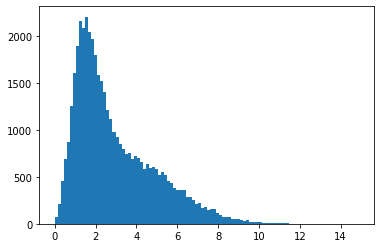

In [ ]:
plt.hist(data_wind, bins = 100)
plt.show()

In [ ]:
#fitting in the distribution
f = Fitter(data_wind,distributions=['gamma',
                          'lognorm',
                          "beta",
                          "norm", 
                          "weibull_min", "weibull_max"])
f.fit()
#get the best fitted distribution
result = f.get_best(method = 'sumsquare_error')
result

{'lognorm': {'loc': -0.3261075478874381,
  's': 0.5967930605107472,
  'scale': 2.744423415340676}}

In [ ]:
s = result['lognorm']['s']
loc = result['lognorm']['loc']
scale = result['lognorm']['scale']

In [ ]:
x = np.linspace(min(data_wind),max(data_wind),1000)
dist = f.fitted_pdf['lognorm']
pdff = lognorm.pdf(x, s, loc, scale)

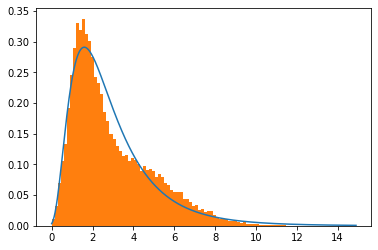

In [ ]:
plt.plot(x,pdff)
plt.hist(data_wind,bins = 100,density = True)
plt.show()

In [ ]:
r = lognorm.rvs(s, loc, scale, size=len(data_wind), random_state=None)
MSE = np.square(np.subtract(data_wind,r))
ARMS = np.sqrt(np.sum(MSE))/len(data_wind)
ARMS

0.013895124796081734

**Probablistic modelling of Solar GHI**

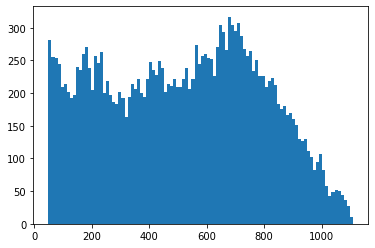

In [ ]:
plt.hist(data_ghi, bins = 100)
plt.show()

In [ ]:
f = Fitter(data_ghi,distributions=['gamma',
                          'lognorm',
                          "beta",
                          "norm", 
                          "weibull_min", "weibull_max"])
f.fit()

result = f.get_best(method = 'sumsquare_error')
result

{'beta': {'a': 1.1590895393590985,
  'b': 1.525666391285132,
  'loc': 49.66504141704924,
  'scale': 1058.8895498288596}}

In [ ]:
a = result['beta']['a']
b = result['beta']['b']
loc = result['beta']['loc']
scale = result['beta']['scale']

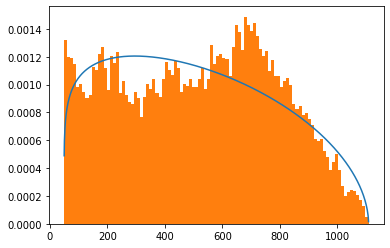

In [ ]:
x = np.linspace(min(data_ghi),max(data_ghi),1200)
pdff = beta.pdf(x, a, b, loc, scale)
plt.plot(x,pdff)
plt.hist(data_ghi,bins = 100,density = True)
plt.show()

In [ ]:
r = beta.rvs(a,b, loc, scale, size=len(data_ghi), random_state=None)
MSE = np.square(np.subtract(data_ghi,r))
ARMS = np.sqrt(np.sum(MSE))/len(data_ghi)
ARMS/100

0.026949321311865795

**Modelling of loading**

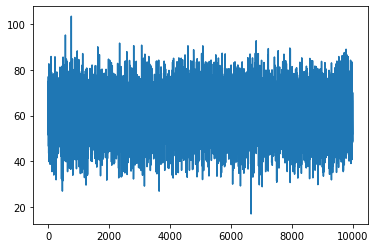

In [ ]:
mu, sigma = 10, 10 # mean and standard deviation
data_load = 50 + np.random.normal(mu, sigma, 10000)
plt.plot(data_load)

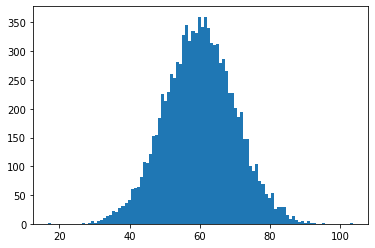

In [ ]:
plt.hist(data_load, bins = 100)
plt.show()

In [ ]:
f = Fitter(data_load,distributions=['norm'])
f.fit()

result = f.get_best(method = 'sumsquare_error')
result

{'norm': {'loc': 59.97746860192416, 'scale': 9.966081371226052}}

The probablity density function for the normal distribution is given as: 

$$f(x) = \frac{e^{-\frac{1}{2}(\frac{x-\mu}{σ})^2}}{\sigma \sqrt{2\pi}}$$

The mean and variance from distribuion function $f(x)$ can be obtained as for range $[a,b]$: 
$$\mu  = EX[x]= \int_{a}^b xf(x)d(x)$$

$$VAR  =  \int_{a}^b (x-\mu)^2f(x)d(x)$$

$$\sigma = \sqrt{VAR}$$
This is also called as central moments $\mu_n$

$n^{th}$ raw moment of the probablity distribution function is givne as:

$$\mu'_n = \int_{-\infty}^{\infty}x^nf(x)dx$$

Let $\phi(t)$ be the characteristis function, defined as the Fourier transform of the probablity density function $f(x)$:

$$\phi(t) = F_x[f(x)](t)$$
$$ = \int_{-\infty}^{\infty}e^{itx}f(x)dx $$
The cummulants $k_n$ are then defined by

$$ln (\phi(t)) = \sum_{n=1}^\infty k_n \frac{(it)^n}{n!} $$
Expanding and comapring the both sides
we will get the cummulants as follows:

\begin{aligned}\kappa _{1}={}&\mu '_{1}\\[4pt]\kappa _{2}={}&\mu '_{2}-{\mu '_{1}}^{2}\\[4pt]\kappa _{3}={}&\mu '_{3}-3\mu '_{2}\mu '_{1}+2{\mu '_{1}}^{3}\\[4pt]\kappa _{4}={}&\mu '_{4}-4\mu '_{3}\mu '_{1}-3{\mu '_{2}}^{2}+12\mu '_{2}{\mu '_{1}}^{2}-6{\mu '_{1}}^{4}\\[4pt]\kappa _{5}={}&\mu '_{5}-5\mu '_{4}\mu '_{1}-10\mu '_{3}\mu '_{2}+20\mu '_{3}{\mu '_{1}}^{2}+30{\mu '_{2}}^{2}\mu '_{1}-60\mu '_{2}{\mu '_{1}}^{3}+24{\mu '_{1}}^{5}\\[4pt]\kappa _{6}={}&\mu '_{6}-6\mu '_{5}\mu '_{1}-15\mu '_{4}\mu '_{2}+30\mu '_{4}{\mu '_{1}}^{2}-10{\mu '_{3}}^{2}+120\mu '_{3}\mu '_{2}\mu '_{1}\\&{}-120\mu '_{3}{\mu '_{1}}^{3}+30{\mu '_{2}}^{3}-270{\mu '_{2}}^{2}{\mu '_{1}}^{2}+360\mu '_{2}{\mu '_{1}}^{4}-120{\mu '_{1}}^{6}\end{aligned}


Now we can approximate the distribution function that has the cumulants with the help of expansion such as gram-charlier expansion, edgeworth expansion and so on:
The approximate gram-charlier expansion can be written as:

$$ f(x)\approx {\frac {1}{{\sqrt {2\pi }}\sigma }}\exp \left[-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}\right]\left[1+{\frac {\kappa _{3}}{3!\sigma ^{3}}}He_{3}\left({\frac {x-\mu }{\sigma }}\right)+{\frac {\kappa _{4}}{4!\sigma ^{4}}}He_{4}\left({\frac {x-\mu }{\sigma }}\right)\right]\,,$$

The $He_{i}(x)$ is Hermite polynomial and for fourth order can be given as:
$$He_{3}(x)=x^{3}-3x$$
$$He_{4}(x)=x^{4}-6x^{2}+3$$
and $\mu = \kappa_1$ is the mean of the distribution and $\sigma = \sqrt{\kappa_2}$

In [ ]:
from scipy.integrate import quad
from scipy.special import gamma, hermite, factorial

In [ ]:
mean = 10
sigma = 5

In [ ]:
def dist_fun_norm(x):
  return (np.exp(-0.5*np.square((x-mean)/sigma)))/(sigma*np.sqrt(2*np.pi))

def dist_fun_weibul_min(x):
  return (c*x**(c-1) * np.exp(-x**c))

def dist_fun_lognorm(x):
  return ((1/(s*x*np.sqrt(2*np.pi)))*np.exp(-(np.log(x)**2)/(2*s**2)) )

def dist_fun_gamma(x):
  return (x**(a-1)*np.exp(-x)/(gamma(a)))

def dist_fun_lamda(x):
  return (np.exp(-l*x))

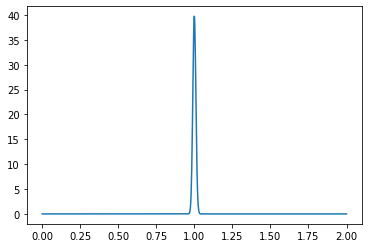

In [ ]:
s = 0.01
x = np.linspace(00.0001,2,1000)
y = dist_fun_lognorm(x)
plt.plot(x,y)

In [ ]:
def raw_moment(dist_fun,order):
  def integrand(x):
    y = ((x)**order)*dist_fun(x)
    return y
  I = quad(integrand, 0, np.inf)
  return I[0]

def raw_moment_order(dist_fun,order):
  u = []
  for i in range(order):
    u.append(raw_moment(dist_fun,i+1))
  return u

In [ ]:
u1,u2,u3,u4,u5,u6 = raw_moment_order(dist_fun_lognorm,6)
print(u1,u2,u3,u4,u5,u6)

1.0000500012500209 1.0002000200013335 1.0004501012651892 1.0008003200853504 1.0012507815756224 1.0018016209724374


In [ ]:
#cumulants from moments from wikipedia
#https://en.wikipedia.org/wiki/Cumulant
def cumulants_from_moments(u1,u2,u3,u4,u5,u6):
  k1 = u1
  k2 = u2-u1**2
  k3 = u3-3*u1*u2 + 2*u1**3
  k4 = u4 - 4*u3*u1 - 3*u2**2 + 12* u2*u1**2 - 6*u1**4
  k5 = u5 - 5*u4*u1 - 10*u3*u2 + 20*u3*u1**2 + 30*u2**2*u1 - 60 * u2*u1**3 + 24*u1**5
  k6 = u6 - 6*u5*u1 - 15*u4*u2 + 30*u4*u1**2 - 10*u3**2 + 120*u3*u2*u1 - 120*u3*u1**3 + 30*u2**3 - 270*u2**2*u1**2 + 360*u2*u1**4 - 120*u1**6
  return (k1,k2,k3,k4,k5,k6)

In [ ]:
k1, k2, k3, k4,k5,k6 = cumulants_from_moments(u1,u2,u3,u4,u5,u6)
print(k1,k2,k3,k4,k5,k6)

1.0000500012500209 0.00010001500116674222 3.000850101742003e-08 1.6008527836675057e-11 7.105427357601002e-15 -2.842170943040401e-14


In [ ]:
def gram_charlie_approx(k2,k3,k4,y):
  sigma = np.sqrt(k2)
  y = (1 + (k3/(6*sigma**3)*(y**3 - 3*y) + (k4/(24*sigma**4))*(y**4 - 6*y**2 + 3)))* ((np.exp(-0.5*np.square(y)))/(sigma*np.sqrt(2*np.pi)))
  return y


In [ ]:
def gram_charlie_approx1(k2,k3,k4,y):
  sigma = np.sqrt(k2)
  y = (1 + (k3/(factorial(3)*sigma**3))*hermite(3,monic= True)(y) + (k4/(factorial(4)*sigma**4))*hermite(4,monic= True)(y) + (k5/(factorial(5)*sigma**5))*hermite(5,monic = True)(y) + (k6/(factorial(6)*sigma**6))*hermite(6,monic = True)(y))* ((np.exp(-0.5*np.square(y)))/(sigma*np.sqrt(2*np.pi)))
  return y

In [ ]:
x = np.linspace(0.001,2,10000)
mu = k1
sigma = np.sqrt(k2)
y = (x-mu)/sigma

y_approx = gram_charlie_approx1(k2,k3,k4,y)


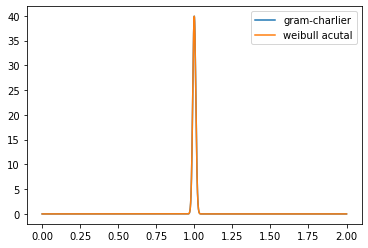

In [ ]:
y_actual = dist_fun_lognorm(x)
plt.plot(x,y_approx, label = "gram-charlier")

plt.plot(x,y_actual,label = 'weibull acutal')
plt.legend()


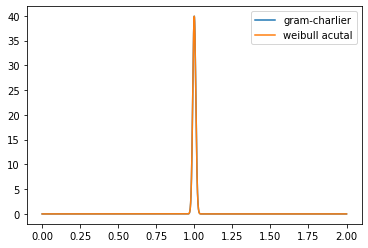

In [ ]:
y_actual = dist_fun_lognorm(x)
plt.plot(x,y_approx, label = "gram-charlier")

plt.plot(x,y_actual,label = 'weibull acutal')
plt.legend()


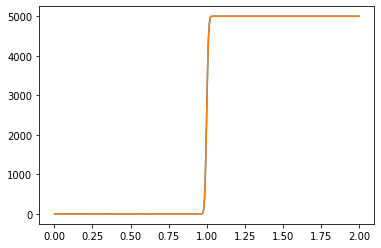

In [ ]:
plt.plot(x,y_approx.cumsum())
plt.plot(x,y_actual.cumsum())

In [ ]:
1/5000

0.0002

In [ ]:
560/np.sqrt(2)

395.97979746446657

In [ ]:
1/(2*np.pi*50)

0.0031830988618379067

In [ ]:
5/(2*np.pi*50)

0.015915494309189534